# CO2 Emissions Classification Model

## Objective
Develop an ML model to predict whether CO2 emissions from specific sources will increase or decrease based on historical data. The target variable is categorical, representing the two classes: increase (1) or decrease (0). This model will be a supervised, binary classification model.

## Success Metrics
- Achieve at least 80% recall for predicting increases in emissions on both the training and test sets.
- The model will be considered a failure if:
  - After three months of deployment, more than 30% of predicted increases in emissions are incorrect.
  - The precision for predicting decreases in emissions is lower than 80% on both the training and test sets.

## Model Output
A flag indicating whether CO2 emissions will increase or decrease, along with the associated probability. Predictions will be made in real-time, based on input data provided by environmental analysts.

## Training Data
Historical data on CO2 emissions, excluding non-predictive variables like unique identifiers.

## Inputs
- outputs/datasets/collection/Co2Emissions.csv
- Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs
- Train set (features and target)
- Test set (features and target)
- ML pipeline to predict Co2 Increase or Decrease
- labels map
- Feature Importance Plot


# Change working directory

We need to change the working directory from its current folder to its parent folder
-    We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Grampers\\Desktop\\CO2Oracle\\jupyter_notebooks'

I want to make the parent of the current directory the new current directory.
- os.path.dirname() gets the parent directory
- os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Grampers\\Desktop\\CO2Oracle'

## Load Data
- Load the dataset and display basic information.

In [4]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv('C:outputs\datasets\collection\Co2Emissions.csv')

# Display basic information
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63104 entries, 0 to 63103
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     63104 non-null  object 
 1   Year        63104 non-null  int64  
 2   Total       62904 non-null  float64
 3   Coal        21744 non-null  float64
 4   Oil         21717 non-null  float64
 5   Gas         21618 non-null  float64
 6   Cement      20814 non-null  float64
 7   Flaring     21550 non-null  float64
 8   Other       1620 non-null   float64
 9   Per Capita  18974 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 4.8+ MB
None
               Year         Total          Coal           Oil           Gas  \
count  63104.000000  62904.000000  21744.000000  21717.000000  21618.000000   
mean    1885.500000     55.224788     73.968916     55.760624     23.504285   
std       78.519728    824.845435    598.986992    519.034563    247.674772   
min     1750.000

In [5]:
# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

## Check for missing values and define the target variable and features.

- Calculate the year-over-year change in CO2 emissions.
- Create a binary target variable: Use the change in emissions to create a binary target variable where 1 indicates an increase and 0 indicates a decrease.

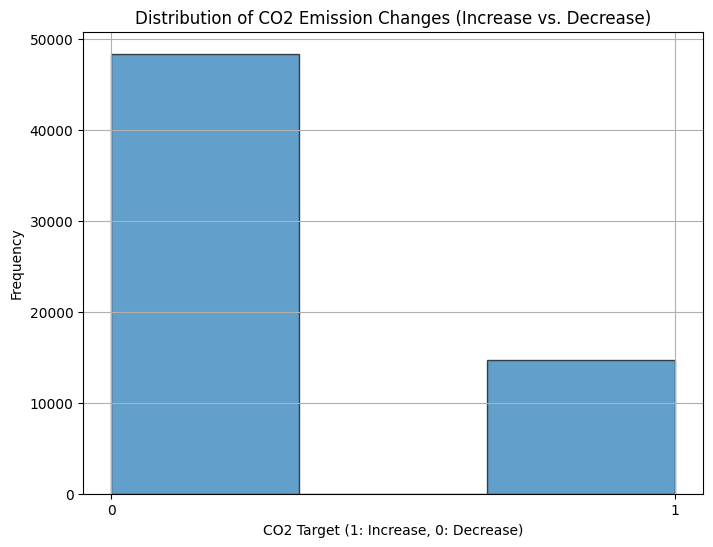

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Impute missing values with the median for numeric columns
imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Drop rows with missing values in non-numeric columns
df = df.dropna(subset=non_numeric_cols)

# Feature engineering
df['Total_Lag1'] = df.groupby('Country')['Total'].shift(1)
df['Total_Lag2'] = df.groupby('Country')['Total'].shift(2)
df['Total_Lag3'] = df.groupby('Country')['Total'].shift(3)
df['Total_Rolling_Mean'] = df.groupby('Country')['Total'].rolling(window=3).mean().reset_index(level=0, drop=True)
df['Total_Rolling_Std'] = df.groupby('Country')['Total'].rolling(window=3).std().reset_index(level=0, drop=True)
df['Cumulative_Total'] = df.groupby('Country')['Total'].cumsum()
df['Coal_Gas_Interaction'] = df['Coal'] * df['Gas']
df['Oil_Flaring_Interaction'] = df['Oil'] * df['Flaring']
df['Year_on_Year_Change'] = df.groupby('Country')['Total'].pct_change(periods=12)
df['Coal_Percentage'] = df['Coal'] / df['Total']
df['Gas_Percentage'] = df['Gas'] / df['Total']
df['Oil_Percentage'] = df['Oil'] / df['Total']
df['Flaring_Percentage'] = df['Flaring'] / df['Total']

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute remaining missing values with the median
df = df.fillna(df.median(numeric_only=True))

# Drop the CO2_Change column if missing values remain
df = df.drop(columns=['CO2_Change'], errors='ignore')

# CO2 Change and Target Variable
df['CO2_Target'] = (df['Total'].pct_change() > 0).astype(int)

# Drop rows with missing CO2_Target
df = df.dropna(subset=['CO2_Target'])

# Ensure no missing values are present
assert df.isnull().sum().sum() == 0, "There are still missing values in the dataset!"

# Scale the features
scaler = StandardScaler()
X = df.drop(['CO2_Target', 'Country'], axis=1)
X_scaled = scaler.fit_transform(X)
y = df['CO2_Target']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
plt.hist(y, bins=3, edgecolor='k', alpha=0.7)
plt.title('Distribution of CO2 Emission Changes (Increase vs. Decrease)')
plt.xlabel('CO2 Target (1: Increase, 0: Decrease)')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.grid(True)
plt.show()



## MP Pipeline: Regressor
- Create ML pipeline

In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Country'])),

        ("imputer", SimpleImputer(strategy="mean")),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

Custom Class for hyperparameter optimisation

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [9]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = df.drop(['CO2_Target'], axis=1)  # Drop unnecessary columns
y = df['CO2_Target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (50483, 23) (50483,) 
* Test set: (12621, 23) (12621,)


In [10]:

print(X_train.info())
print(X_train.head())
print(y_train.info())
print(y_train.head(111))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50483 entries, 26254 to 2732
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  50483 non-null  object 
 1   Year                     50483 non-null  float64
 2   Total                    50483 non-null  float64
 3   Coal                     50483 non-null  float64
 4   Oil                      50483 non-null  float64
 5   Gas                      50483 non-null  float64
 6   Cement                   50483 non-null  float64
 7   Flaring                  50483 non-null  float64
 8   Other                    50483 non-null  float64
 9   Per Capita               50483 non-null  float64
 10  Total_Lag1               50483 non-null  float64
 11  Total_Lag2               50483 non-null  float64
 12  Total_Lag3               50483 non-null  float64
 13  Total_Rolling_Mean       50483 non-null  float64
 14  Total_Rolling_Std  

## Grid Search CV - Sklearn
- Use default hyperparameters to find most suitable algorithm

In [11]:
models_quick_search = {
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [12]:
# Inspect the dataframe to check column names and types
print(df.info())
print(df.head())
X_train.info()
X_train.head()
y_train.info()
y_train.head(111)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63104 entries, 0 to 63103
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  63104 non-null  object 
 1   Year                     63104 non-null  float64
 2   Total                    63104 non-null  float64
 3   Coal                     63104 non-null  float64
 4   Oil                      63104 non-null  float64
 5   Gas                      63104 non-null  float64
 6   Cement                   63104 non-null  float64
 7   Flaring                  63104 non-null  float64
 8   Other                    63104 non-null  float64
 9   Per Capita               63104 non-null  float64
 10  Total_Lag1               63104 non-null  float64
 11  Total_Lag2               63104 non-null  float64
 12  Total_Lag3               63104 non-null  float64
 13  Total_Rolling_Mean       63104 non-null  float64
 14  Total_Rolling_Std     

26254    0
29205    0
31860    0
20362    0
52709    0
        ..
28023    0
21823    0
33155    0
18994    0
17663    0
Name: CO2_Target, Length: 111, dtype: int32

In [13]:
# Create an instance of HyperparameterOptimizationSearch
search = HyperparameterOptimizationSearch(models_quick_search, params_quick_search)

# Fit the search object to the training data
search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring='r2')



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,XGBRegressor,0.532736,0.550904,0.56337,0.010662
1,RandomForestRegressor,0.380706,0.393677,0.415957,0.013749
0,DecisionTreeRegressor,0.195968,0.220563,0.24623,0.018416


## Do an extensive search on the most suitable model to find the best hyperparameter configuration.
- Define model and parameters, for Extensive Search

In [15]:
models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [100, 300],
        'model__max_depth': [3, 10, None],
    }
}

Extensive GridSearch CV

In [16]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Check results

In [17]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
3,RandomForestRegressor,0.529818,0.542694,0.555173,0.008771,10,300
2,RandomForestRegressor,0.529762,0.542547,0.555202,0.008774,10,100
0,RandomForestRegressor,0.52167,0.53452,0.543175,0.007337,3,100
1,RandomForestRegressor,0.521626,0.534518,0.543132,0.007362,3,300
5,RandomForestRegressor,0.382208,0.395044,0.41563,0.013247,None,300
4,RandomForestRegressor,0.380706,0.393677,0.415957,0.013749,None,100


Check the best model

In [18]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

Parameters for best model

In [19]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 10, 'model__n_estimators': 300}

Define the best regressor, based on search

In [20]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Country'])),
                ('imputer', SimpleImputer()),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=300,
                                       random_state=0))])

Assess feature importance

In [21]:
data_cleaning_feat_eng_steps = 3  # Replace with the actual number of data cleaning and feature engineering steps

columns_after_data_cleaning_feat_eng = pd.DataFrame(Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                                    .transform(X_train)).columns


Evaluate on Train and Test Sets

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, learning_curve
sns.set_style('whitegrid')

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)
    
    train_score = r2_score(y_train, pipeline.predict(X_train))
    test_score = r2_score(y_test, pipeline.predict(X_test))
    print("Difference in R2 Score:", train_score - test_score)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

def cross_validation_evaluation(X_train, y_train, pipeline, cv=5):
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2')
    print("Cross-Validation R2 Scores:", cv_scores)
    print("Mean Cross-Validation R2 Score:", np.mean(cv_scores))
    print("Standard Deviation of Cross-Validation R2 Score:", np.std(cv_scores))

def plot_learning_curves(pipeline, X_train, y_train, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        pipeline, X_train, y_train, cv=cv, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()




Evaluate Performance

In [23]:
def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', round(r2_score(y, prediction), 3))
    print('Mean Absolute Error:', round(mean_absolute_error(y, prediction), 3))
    print('Mean Squared Error:', round(mean_squared_error(y, prediction), 3))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y, prediction)), 3))
    print("\n")



## Regressor with PCA
- Let's explore potential values for PCA n_components.

In [25]:
if 'CO2_Change' in df.columns:
    df_pca = pipeline_pca.fit_transform(df.drop(['CO2_Change'], axis=1))
else:
    df_pca = pipeline_pca.fit_transform(df)


### Apply PCA separately to the scaled data

In [26]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 7


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


* The 7 components explain 100.0% of the data 



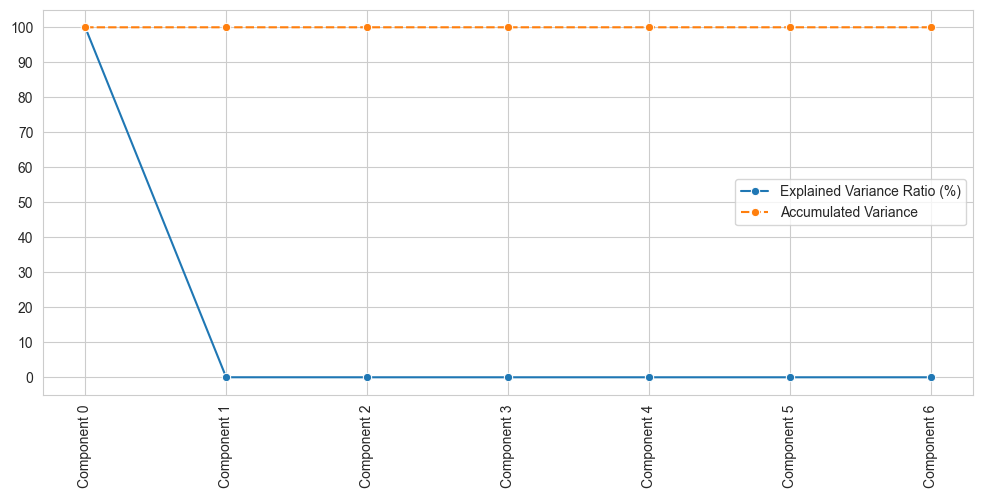

In [27]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [28]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Country'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
        
        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

## Grid Search CV – Sklearn

In [29]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (50483, 23) (50483,) 
* Test set: (12621, 23) (12621,)


## Use standard hyperparameters to find the most suitable model.

In [30]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

- Do a quick optimisation search

In [31]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [32]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
6,XGBRegressor,0.548554,0.566076,0.58183,0.013728
2,RandomForestRegressor,0.539288,0.558554,0.577212,0.014369
3,ExtraTreesRegressor,0.510197,0.528491,0.546795,0.013021
5,GradientBoostingRegressor,0.470636,0.486868,0.508349,0.014367
4,AdaBoostRegressor,0.267225,0.325143,0.366822,0.036115
1,DecisionTreeRegressor,0.231994,0.254375,0.277887,0.015605
0,LinearRegression,0.017963,0.023089,0.030118,0.004114


## Do an extensive search on the most suitable model to find the best hyperparameter configuration.
- Define model and parameters for extensive search

In [33]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html


params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [100, 300],   # Number of trees in the forest
        'model__max_depth': [3, 10, None],  # Maximum depth of the tree
        'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'model__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'model__bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    }
}

Extensive GridSearch CV

In [34]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Check results

In [35]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__bootstrap,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
53,RandomForestRegressor,0.567689,0.583998,0.602116,0.012821,True,None,4,10,300
52,RandomForestRegressor,0.567264,0.583019,0.601354,0.012819,True,None,4,10,100
51,RandomForestRegressor,0.565905,0.582644,0.600939,0.013056,True,None,4,5,300
49,RandomForestRegressor,0.565905,0.582644,0.600939,0.013056,True,None,4,2,300
50,RandomForestRegressor,0.566063,0.581978,0.600282,0.013019,True,None,4,5,100
...,...,...,...,...,...,...,...,...,...,...
55,RandomForestRegressor,0.269178,0.326399,0.366202,0.035258,False,3,1,2,300
69,RandomForestRegressor,0.269178,0.326399,0.366202,0.035258,False,3,4,5,300
71,RandomForestRegressor,0.269178,0.326399,0.366202,0.035258,False,3,4,10,300
91,RandomForestRegressor,0.304428,0.322605,0.338757,0.012274,False,None,1,2,300


Check the best model

In [36]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

## Parameters for best model

- We are saving this content for later

In [37]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__bootstrap': True,
 'model__max_depth': None,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 10,
 'model__n_estimators': 300}

Define the best reg pipeline

In [38]:
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Country'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('imputer', SimpleImputer()),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model',
                 RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                                       n_estimators=300, random_state=0))])

## Assess feature importance
- We can assess feature importance for this model with .feature_importances_

In [ ]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_reg.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_reg['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_reg['feat_selection'].get_support()],
    'Importance': pipeline_reg['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [62]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()



Evaluate Performance

In [63]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Model Evaluation 

* Train Set


AttributeError: 'float' object has no attribute 'round'

## Regressor with PCA
- Let's explore potential values for PCA n_components.

In [83]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['CO2_Change'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

KeyError: "['CO2_Change'] not found in axis"

### Apply PCA separately to the scaled data

* The 7 components explain 100.0% of the data 



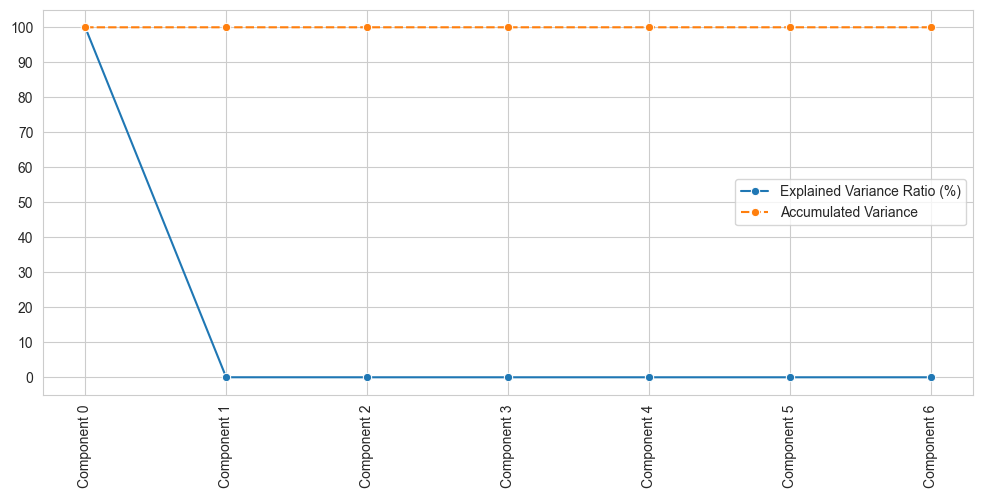

In [52]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 7


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 7 components explain 100.0% of the data 



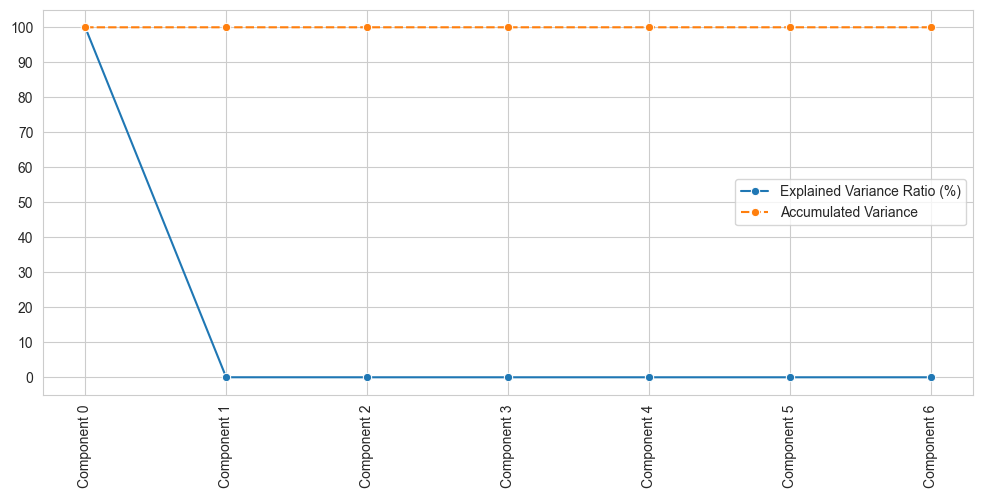

In [53]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

# Rewrite ML Pipeline for Modelling

In [54]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Country'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

## Grid Search CV – Sklearn

In [55]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (50483, 23) (50483,) 
* Test set: (12621, 23) (12621,)


## Use standard hyperparameters to find the most suitable model.

In [56]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a quick optimisation search

In [57]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

In [58]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
6,XGBRegressor,0.548554,0.566076,0.58183,0.013728
2,RandomForestRegressor,0.539288,0.558554,0.577212,0.014369
3,ExtraTreesRegressor,0.510197,0.528491,0.546795,0.013021
5,GradientBoostingRegressor,0.470636,0.486868,0.508349,0.014367
4,AdaBoostRegressor,0.267225,0.325143,0.366822,0.036115
1,DecisionTreeRegressor,0.231994,0.254375,0.277887,0.015605
0,LinearRegression,0.017963,0.023089,0.030118,0.004114


## Do an extensive search on the most suitable model to find the best hyperparameter configuration.
- Define model and parameters for extensive search

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

models_search = {
    "XGBRegressor":XGBRegressor(random_state=0),
}


# Documentation for XGBRegressor:
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor

params_search = {
    "XGBRegressor": {
        'model__n_estimators': [100, 300],
        'model__learning_rate': [0.1, 0.01, 0.001], 
        'model__max_depth': [3, 10, 20]  # Removed None since max_depth expects an int
    }
}


## Extensive GridSearch CV

In [79]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=6)


Running GridSearchCV for XGBRegressor 

Fitting 6 folds for each of 18 candidates, totalling 108 fits


Check results

In [81]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
2,XGBRegressor,0.540688,0.56134,0.5753,0.011036,0.1,10,100
1,XGBRegressor,0.49948,0.538009,0.550694,0.01743,0.1,3,300
9,XGBRegressor,0.487106,0.534136,0.554144,0.022186,0.01,10,300
3,XGBRegressor,0.502694,0.529873,0.550739,0.014263,0.1,10,300
11,XGBRegressor,0.488175,0.512034,0.526973,0.011937,0.01,20,300
4,XGBRegressor,0.456591,0.479598,0.497406,0.012315,0.1,20,100
0,XGBRegressor,0.40785,0.477275,0.508348,0.033384,0.1,3,100
5,XGBRegressor,0.440324,0.46415,0.48187,0.012554,0.1,20,300
10,XGBRegressor,0.379265,0.435663,0.464084,0.026693,0.01,20,100
8,XGBRegressor,0.307977,0.369862,0.413786,0.034482,0.01,10,100


Check the best model

In [67]:
best_model = grid_search_summary.iloc[0,0]
best_model

'XGBRegressor'

Parameters for best model

In [68]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 10,
 'model__n_estimators': 100}

Define the best regressor

In [69]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Country'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model',
                 XGBRegressor(base_score=None, booster=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

## Evaluate Regressor on Train and Tests Sets

In [73]:
def regression_evaluation(X, y, Pipeline):
    prediction = Pipeline.predict(X)
    print('R2 Score:', round(r2_score(y, prediction), 3))
    print('Mean Absolute Error:', round(mean_absolute_error(y, prediction), 3))
    print('Mean Squared Error:', round(mean_squared_error(y, prediction), 3))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y, prediction)), 3))
    print("\n")


In [75]:
regression_evaluation(X_test, y_test, best_regressor_pipeline)


R2 Score: 0.566
Mean Absolute Error: 0.142
Mean Squared Error: 0.077
Root Mean Squared Error: 0.278




## Convert Regression to Classification
- Convert numerical target to bins, and check if it is balanced

In [110]:
from imblearn.over_sampling import SMOTE

# Assuming X and y are defined
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(df.drop(columns=['Total']), df['Total'])

# Proceed with your discretization and modeling



ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

* The classes represent the following ranges: 
{'Total': [-inf, 0.010992, inf]} 



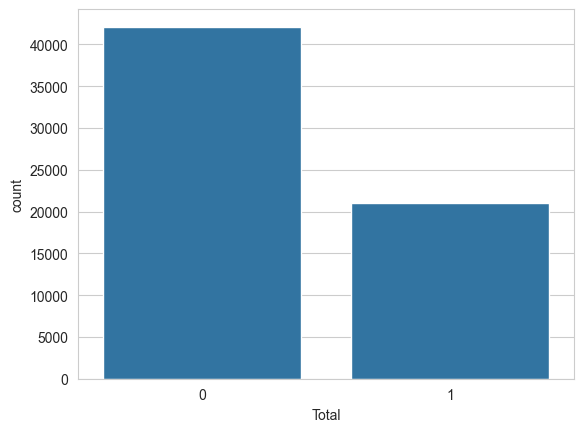

In [107]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=3, variables=['Total'])  # we will try q as 2, and 3
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='Total')
plt.show()